In [1]:
# import warnings filter
from warnings import simplefilter
import warnings
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')


In [2]:
import pandas as pd
import numpy as np
import ast
from itertools import combinations, product
from sklearn import manifold
import matplotlib.pyplot as plt
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import textblob
import re

In [3]:
df = pd.read_csv("output_combined_location.csv")

In [4]:
#Get the tweets
#Get the frequency of the countries mentioned
df.head()

,id,username,text,retweets,favorites,replies,permalink,date,mentions,hashtags,Tweet_Token,Tweet_Location_Found
0,1200516560160481280,vanderfullife,Pan Pacific Airlines adds Clark – Muan route f...,0,0,0,https://twitter.com/vanderfullife/status/12005...,2019-11-29 20:47:07+00:00,NaN,#news #today #travel #vacation #cruise #holida...,"['Pan', 'Pacific', 'Airlines', 'adds', 'Clark'...",['pan']
1,1200516487389122560,sweetsteph0914,Today I was presented w/ an #eviction notice (...,0,0,0,https://twitter.com/sweetsteph0914/status/1200...,2019-11-29 20:46:49+00:00,@Twitter,#eviction #holidays,"['Today', 'I', 'was', 'presented', 'w', '/', '...","['at', 'can', 'me', 'my', 'to']"
2,1200516453612568576,PhilMorseRE,Earning extra money during the #holidays can m...,0,0,0,https://twitter.com/PhilMorseRE/status/1200516...,2019-11-29 20:46:41+00:00,NaN,#holidays #creditcards,"['Earning', 'extra', 'money', 'during', 'the',...","['can', 'it', 'to']"
3,1200516306967154688,HollyNorth,"Oh the weather outside is frightful, and our s...",0,0,0,https://twitter.com/HollyNorth/status/12005163...,2019-11-29 20:46:06+00:00,NaN,#Holidays #HollyNorth #HollyNorthProductionSup...,"['Oh', 'the', 'weather', 'outside', 'is', 'fri...","['and', 'is', 'it', 'so']"
4,1200516102205239296,LissaandTiniRay,Hanging with some of my favs @CranbrookLiquo1 ...,0,0,0,https://twitter.com/LissaandTiniRay/status/120...,2019-11-29 20:45:17+00:00,@CranbrookLiquo1,#g4tequila #liquorstores #tastings #lovethiscr...,"['Hanging', 'with', 'some', 'of', 'my', 'favs'...","['and', 'my']"


In [5]:
no_null_values = df["Tweet_Location_Found"].dropna()

In [6]:
destinations = df.iloc[no_null_values.index]

In [7]:
def convert_to_array(val):
    str1 = val.replace(']','').replace('[','')
    l = str1.split(",")
    return l

In [8]:
#let's remove stop words from the tweet token
stop_words = set(stopwords.words('english')) 

In [9]:
def splitter(data):
    new_data = []
    for word in data:    
        word = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",word.lower())
        new_data.append(textblob.Word(word.strip()).lemmatize())
    return new_data

In [10]:
def remove_stop_words(word_tokens):   
    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w)
    return filtered_sentence

In [11]:
destinations["Tweet_Token"] = destinations["Tweet_Token"].apply(lambda x: convert_to_array(x))
destinations["Tweet_Token_Stop_Words"] = destinations["Tweet_Token"].apply(lambda x: remove_stop_words(x))
destinations["Tweet_Token_Stop_Words"] = destinations["Tweet_Token_Stop_Words"].apply(lambda x: splitter(x))

In [ ]:
destinations["Tweet_Location_Found"] = destinations["Tweet_Location_Found"].apply(lambda x: convert_to_array(x))

In [ ]:
destinations.head()

In [12]:
def word_freq(word_list):
    word_map = {}
    for a in word_list:
        for word in a:
            if word in word_map:
                word_map[word] += 1
            else:
                word_map.update({word : 1})
    return sorted(word_map.items(), key=lambda kv: kv[1],reverse=True)

In [13]:
word_freq(destinations["Tweet_Token_Stop_Words"])

[('', 71233),
 ('the', 8573),
 ('holiday', 7544),
 ('to', 6487),
 ('a', 5876),
 ('travel', 5822),
 ('vacation', 5661),
 ('and', 4965),
 ('for', 4653),
 ('destination', 4477),
 ('in', 3983),
 ('of', 3823),
 ('getaway', 3721),
 ('you', 3099),
 ('your', 2718),
 ('is', 2589),
 ('hotel', 2188),
 ('with', 2135),
 ('on', 1954),
 ('at', 1906),
 ('thanksgiving', 1878),
 ('this', 1615),
 ('flight', 1574),
 ('tour', 1563),
 ('it', 1484),
 ('from', 1314),
 ('trip', 1294),
 ('family', 1287),
 ('our', 1287),
 ('experience', 1286),
 ('are', 1277),
 ('weekend', 1247),
 ('we', 1169),
 ('i', 1165),
 ('cruise', 1091),
 ('u', 1029),
 ('christmas', 1024),
 ('deal', 1003),
 ('all', 1000),
 ('best', 971),
 ('happy', 961),
 ('photography', 934),
 ('be', 932),
 ('day', 894),
 ('time', 872),
 ('my', 847),
 ('new', 833),
 ('escape', 827),
 ('news', 801),
 ('beach', 795),
 ('tourism', 772),
 ('s', 759),
 ('by', 754),
 ('that', 750),
 ('english', 741),
 ('love', 730),
 ('today', 728),
 ('book', 723),
 ('have', 720

In [14]:
top_10_destinations = ["scotland","la","florida","york","turkey","spain","bali","italy","california","india"]

In [18]:
# Calculation of lift scores. Code Gotten from project 1
def do_lift(x, y=None):
    l1, l2 = sorted(x), sorted(y or [])
    bools = pd.DataFrame()
    for e in l1 + l2:
        bools[e] = destinations['Tweet_Token_Stop_Words'].map(lambda words: e in words)

    def do(df, a, b):
        count_a_int_b = np.logical_and(df[a], df[b]).values.sum()
        count_a_mult_count_b = df[a].values.sum() * df[b].values.sum()
        return len(df.index) * count_a_int_b / count_a_mult_count_b

    result_df = pd.DataFrame(index=l1, columns=(l2 or l1))
    for a, b in (combinations(l1, 2) if y==None else product(l1, l2)):
        val = do(bools, a, b)
        result_df.at[a, b] = val
        if y==None:
            result_df.at[b, a] = val

    return result_df

In [19]:
top_destinations = do_lift(top_10_destinations)
topDestinationsList = list(top_destinations.columns)

In [20]:
#Lets take care of the 0 scores by padding the lift values by 0.5
floatdf = top_destinations.astype(float)
floatdf = floatdf.add(0.5)
np.fill_diagonal(floatdf.values, 0)
floatdf

,bali,california,florida,india,italy,la,scotland,spain,turkey,york
bali,0.000000,0.500000,0.50000,3.146347,0.500000,0.500000,0.500000,1.641676,0.500000,0.500000
california,0.500000,0.000000,0.50000,0.500000,0.500000,2.376501,1.030903,0.500000,1.672813,0.500000
florida,0.500000,0.500000,0.00000,0.500000,0.500000,1.528840,0.500000,0.500000,3.072100,0.500000
india,3.146347,0.500000,0.50000,0.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
italy,0.500000,0.500000,0.50000,0.500000,0.000000,2.006887,0.841065,1.233441,0.500000,0.500000
la,0.500000,2.376501,1.52884,0.500000,2.006887,0.000000,0.500000,0.940064,0.952066,0.891553
scotland,0.500000,1.030903,0.50000,0.500000,0.841065,0.500000,0.000000,0.500000,0.500000,0.500000
spain,1.641676,0.500000,0.50000,0.500000,1.233441,0.940064,0.500000,0.000000,0.500000,0.500000
turkey,0.500000,1.672813,3.07210,0.500000,0.500000,0.952066,0.500000,0.500000,0.000000,0.500000
york,0.500000,0.500000,0.50000,0.500000,0.500000,0.891553,0.500000,0.500000,0.500000,0.000000


In [21]:
dissimilarity_matrix = (1/floatdf).astype(float)
np.fill_diagonal(dissimilarity_matrix.values, 0)
dissimilarity_matrix

,bali,california,florida,india,italy,la,scotland,spain,turkey,york
bali,0.000000,2.000000,2.000000,0.317829,2.000000,2.000000,2.000000,0.609133,2.000000,2.000000
california,2.000000,0.000000,2.000000,2.000000,2.000000,0.420787,0.970023,2.000000,0.597795,2.000000
florida,2.000000,2.000000,0.000000,2.000000,2.000000,0.654091,2.000000,2.000000,0.325510,2.000000
india,0.317829,2.000000,2.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
italy,2.000000,2.000000,2.000000,2.000000,0.000000,0.498284,1.188969,0.810740,2.000000,2.000000
la,2.000000,0.420787,0.654091,2.000000,0.498284,0.000000,2.000000,1.063757,1.050347,1.121638
scotland,2.000000,0.970023,2.000000,2.000000,1.188969,2.000000,0.000000,2.000000,2.000000,2.000000
spain,0.609133,2.000000,2.000000,2.000000,0.810740,1.063757,2.000000,0.000000,2.000000,2.000000
turkey,2.000000,0.597795,0.325510,2.000000,2.000000,1.050347,2.000000,2.000000,0.000000,2.000000
york,2.000000,2.000000,2.000000,2.000000,2.000000,1.121638,2.000000,2.000000,2.000000,0.000000


In [22]:
# Plotting MDS plot
seed = np.random.RandomState(seed=3)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, 
      random_state=seed, dissimilarity="precomputed", n_jobs=1)
results = mds.fit(dissimilarity_matrix)
coords = results.embedding_

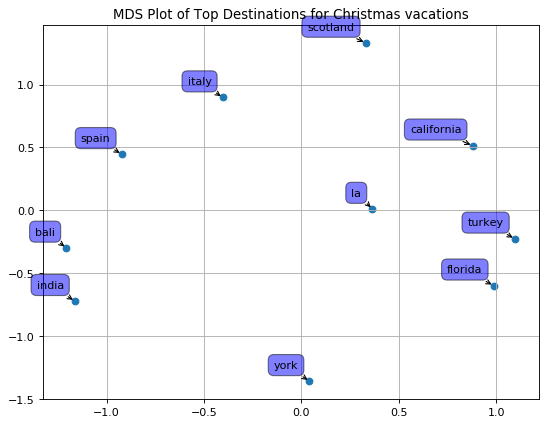

In [23]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(bottom = 0.1)
plt.scatter(coords[:, 0], coords[:, 1], marker = 'o')

for label, x, y in zip(topDestinationsList, coords[:, 0], coords[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-10, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'blue', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.title('MDS Plot of Top Destinations for Christmas vacations')
plt.grid()
plt.show()